In [20]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact
from tqdm.notebook import tqdm

In [55]:
from lucky_investor import luckyInvestor
from unlucky_investor import unluckyInvestor
from som_investor import somInvestor
from random_investor import randomInvestor

In [4]:
df = pd.read_csv('../../collect_tadawul/tadawul_data.csv')

/Users/alialnasser/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df['date'] = pd.to_datetime(df['transactionDateStr'])
df = df[['symbol','previousClosePrice','date']].rename(columns={'previousClosePrice':'price'})

In [6]:
# @interact(symbol = df.groupby(['symbol'])['price'].count().sort_values().tail(30).index)

# def chooseSymbol(symbol):
    
#     lucky_investor = luckyInvestor('lucky',100_0000)
#     unlucky_investor = unluckyInvestor('unlucky',100_0000)
#     som_investor = somInvestor('som',100_0000)
    
#     dfs = df[df['symbol'] == symbol]
#     dfs = dfs.sort_values('date').reset_index(drop=True)
#     dfs['YM'] = dfs['date'].apply(lambda v: v.strftime('%Y-%m'))

#     for ym in np.sort(dfs['YM'].unique()):
#         dfym = dfs[dfs['YM'] == ym]
#         lucky_investor.step(dfym)
#         unlucky_investor.step(dfym)
#         som_investor.step(dfym)

#     plt.figure(figsize=(10,8))

#     plt.plot(lucky_investor.portfolio,label='lucky')
#     plt.plot(unlucky_investor.portfolio,label='unlucky')
#     plt.plot(som_investor.portfolio,label='som')
#     plt.legend()
#     plt.grid()
#     plt.show()

#     for investor in investors:
#         print(investor)
#         print("*"*60)

In [7]:
symbols30 = df.groupby(['symbol'])['price'].count().sort_values().tail(30).index

symbol                   4230
price                   26.75
date      2018-10-23 00:00:00
Name: 372919, dtype: object

In [8]:
symbols = list(symbols30[:30])

  0%|          | 0/256 [00:00<?, ?it/s]

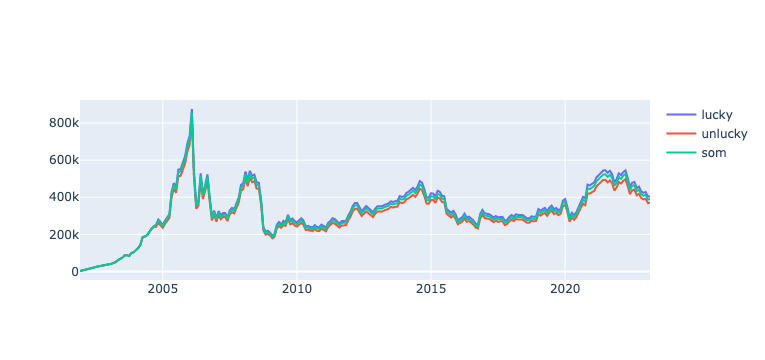

In [58]:
initial_deposit = 0
shares_to_buy = 5
amount_to_deposit_monthly = 1_000

lucky_investor = luckyInvestor('lucky',initial_deposit)
unlucky_investor = unluckyInvestor('unlucky',initial_deposit)
som_investor = somInvestor('som',initial_deposit)
random_investor = randomInvestor('random',initial_deposit)
investors = [lucky_investor,unlucky_investor,som_investor,random_investor]

dfs = df[df['symbol'].apply(lambda symbol: symbol in symbols)]
dfs = dfs.sort_values('date').reset_index(drop=True)
dfs['YM'] = dfs['date'].apply(lambda v: v.strftime('%Y-%m'))
yms = np.sort(dfs['YM'].unique())
pbar = tqdm(yms)
for ym in pbar:
    pbar.set_description("Processing %s" % ym)
    dfym = dfs[dfs['YM'] == ym]
    
    for investor in investors:
        investor.depositMoney(amount_to_deposit_monthly)
    for symbol in symbols: 
        dfym_symbol = dfym[dfym['symbol'] == symbol]
        for investor in investors:
            investor.buyLogic(dfym_symbol,shares=shares_to_buy)
    
    symbols_and_prices = dfym.groupby(['symbol'],as_index=False)['date'].max()
    symbols_and_prices = symbols_and_prices.merge(dfym,on=['symbol','date'])
    stocks = {}
    for i,(symbol,price,date) in symbols_and_prices[['symbol','price','date']].iterrows():
        stocks[int(symbol)] = price
        stocks['date'] = date
        
    for investor in investors:
        investor.updatePortfolio(stocks)
        investor.calculateProfit(stocks)

        
        
fig = go.Figure()

for investor in :
    fig.add_trace(go.Scatter(x=yms, y=investor.portfolio,
                             name=investor.name))

fig.update_layout(hovermode='x unified')
fig.show()   

# for investor in investors:
#     print(investor)
#     print("*"*60)

In [10]:
pd.set_option('display.max_rows', 500)

In [11]:
investors_profit = pd.concat([investor.computeAnnualReturn() for investor in investors])

In [68]:
investors_profit2 = pd.DataFrame()
for investor in investors:
    profit = investor.profit.copy()
    profit.insert(0,'name',investor.name)
    investors_profit2 = pd.concat([investors_profit2,profit])
investors_profit2['year'] = investors_profit2['YM'].apply(lambda v: v[:4])

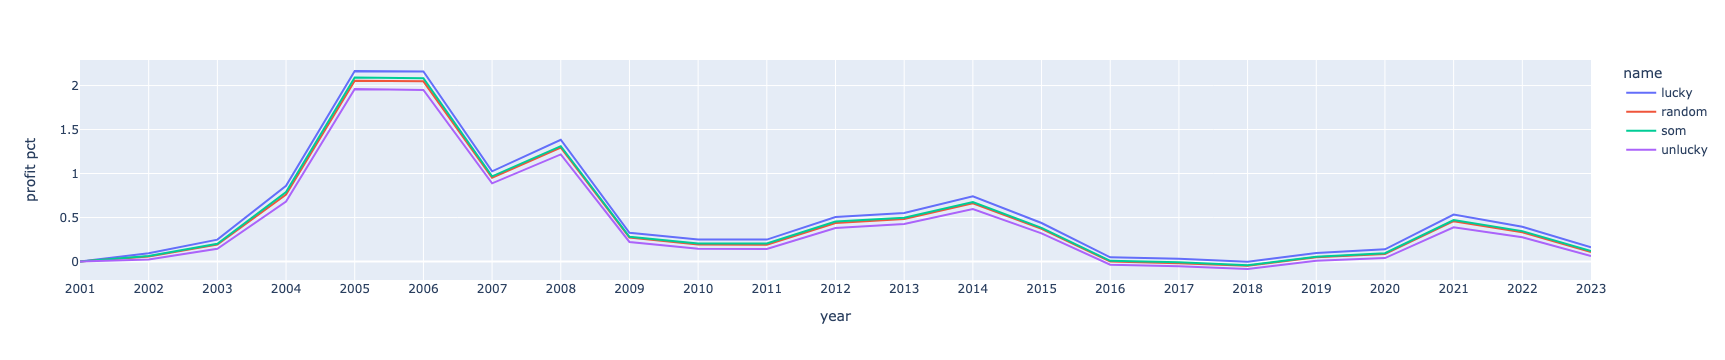

In [64]:
px.line(investors_profit2.groupby(['year','name'],as_index=False)['profit pct'].mean(),
        x='year',y='profit pct',color='name')

In [72]:
pd.crosstab(investors_profit2['year'],
            investors_profit2['name'],
            investors_profit2['profit pct']*100,
            aggfunc='mean',margins=True,margins_name='mean')[[investor.name for investor in investors]]\
  .style.background_gradient(axis=1).format('{:.1f}')

name,lucky,unlucky,som,random
year,,,,
2001,0.0,0.0,0.0,0.0
2002,9.2,2.1,6.3,5.7
2003,24.8,14.5,20.1,19.2
2004,86.1,68.2,78.9,76.0
2005,216.5,196.0,209.1,205.6
2006,216.0,195.0,208.3,204.8
2007,102.5,88.8,96.8,95.1
2008,138.4,121.8,131.0,129.5
2009,32.7,22.2,28.1,27.2


In [13]:
# investors_profit.head(500)

In [14]:
investor.transaction_history

,date,YM,symbol,action,shares,price,total,dca
0,2001-12-31,2001-12,3050,buy,5,45.00,225.00,45.000000
1,2001-12-31,2001-12,1080,buy,5,5.83,29.15,5.830000
2,2001-12-31,2001-12,1020,buy,5,2.38,11.90,2.380000
3,2001-12-31,2001-12,2110,buy,5,150.08,750.40,150.080000
4,2001-12-31,2001-12,3080,buy,5,40.00,200.00,40.000000
...,...,...,...,...,...,...,...,...
2343,2023-03-01,2023-03,3050,buy,5,50.30,251.50,73.133750
2344,2023-03-01,2023-03,1080,buy,5,25.00,125.00,19.277695
2345,2023-03-01,2023-03,1020,buy,5,18.06,90.30,15.210945
2346,2023-03-01,2023-03,2110,buy,5,57.20,286.00,134.236517


In [25]:
investor.transaction_history.groupby(['YM'],as_index=False).agg({'total':'sum',
                                                                 'shares':'sum',
                                                                 'symbol':lambda v:'-'.join(map(str,v))});

In [74]:
for investor in investors:
    print(investor)
    print("**"*30)


name          : lucky
money held    : 17.60
amount spent  : 355982.40
stocks        : [3050, 1080, 1020, 2110, 3080, 1050, 2140, 2170, 3010, 1030, 4030, 3090, 3060, 2070, 4020, 2020, 2050, 4090, 4040, 1120, 4110, 2010, 2060, 4061, 3030, 2080, 4100, 4050, 4150, 1010]
profit        : date            2023-03-16 00:00:00
YM                          2023-03
total profit                49488.5
profit pct                    0.139
Name: 255, dtype: object

    
----------------------------------------
           date       YM symbol action shares   price   total         dca
0    2001-12-31  2001-12   3050    buy      5   45.00  225.00   45.000000
1    2001-12-31  2001-12   1080    buy      5    5.83   29.15    5.830000
2    2001-12-31  2001-12   1020    buy      5    2.38   11.90    2.380000
3    2001-12-31  2001-12   2110    buy      5  150.08  750.40  150.080000
4    2001-12-31  2001-12   3080    buy      5   40.00  200.00   40.000000
...         ...      ...    ...    ...    ...     ...   

In [24]:
for investor in investors:
    px.line(investor.profit,x='date',y='profit pct',labels=investor.name)
    

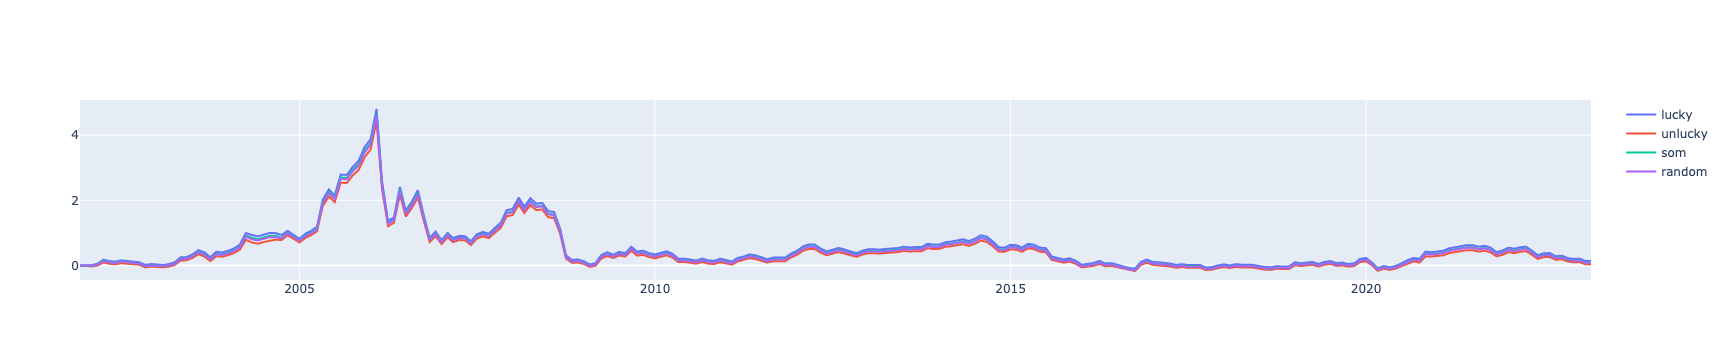

In [73]:

fig = go.Figure()

for investor in investors:
    fig.add_trace(go.Scatter(x=investor.profit.YM, y=investor.profit['profit pct'],
                             name=investor.name))

fig.update_layout(hovermode='x unified')
fig.show()   